In [ ]:
!pip install -q seaborn joblib

import re
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import display
import joblib

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
def parse_formula(formula: str) -> dict:
    tokens = formula.strip().split()
    composition = {}
    for token in tokens:
        match = re.match(r'([A-Z][a-z]?)(\d*\.?\d*)', token)
        if match:
            element, coeff = match.groups()
            coeff = float(coeff) if coeff else 1.0
            composition[element] = coeff
    return composition

def build_alloy_graph(composition: dict) -> nx.Graph:
    G = nx.Graph()
    for element, conc in composition.items():
        if conc > 0:
            G.add_node(element)
    elements = list(G.nodes)
    for i in range(len(elements)):
        for j in range(i + 1, len(elements)):
            G.add_edge(elements[i], elements[j])
    return G

In [ ]:
def double_spike_invariant(graph: nx.Graph, max_nodes: int = 10) -> list:
    nodes = list(graph.nodes)
    node_indices = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)
    inc_matrix = np.zeros((max_nodes, max_nodes), dtype=int)
    for u, v in graph.edges:
        if u in node_indices and v in node_indices:
            i, j = node_indices[u], node_indices[v]
            inc_matrix[i][j] += 1
            inc_matrix[j][i] += 1
    invariant = []
    for i in range(max_nodes):
        if i < n:
            row_sum = np.sum(inc_matrix[i])
            unique = len(set(inc_matrix[i][:n])) - (1 if 0 in inc_matrix[i][:n] else 0)
            invariant.append(row_sum + unique * 7 + i * 3)
        else:
            invariant.append(0)
    return invariant

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/High Entropy Alloy Properties.csv')
target_column = 'PROPERTY: HV'
df_clean = df.dropna(subset=[target_column]).copy()
display(df_clean.head())

,IDENTIFIER: Reference ID,FORMULA,PROPERTY: Microstructure,PROPERTY: Processing method,PROPERTY: BCC/FCC/other,PROPERTY: grain size ($\mu$m),PROPERTY: Exp. Density (g/cm$^3$),PROPERTY: Calculated Density (g/cm$^3$),PROPERTY: HV,PROPERTY: Type of test,PROPERTY: Test temperature ($^\circ$C),PROPERTY: YS (MPa),PROPERTY: UTS (MPa),PROPERTY: Elongation (%),PROPERTY: Elongation plastic (%),PROPERTY: Exp. Young modulus (GPa),PROPERTY: Calculated Young modulus (GPa),PROPERTY: O content (wppm),PROPERTY: N content (wppm),PROPERTY: C content (wppm)
0,27,Al0.25 Co1 Fe1 Ni1,FCC,CAST,FCC,NaN,NaN,7.9,138.0,C,25.0,158.0,NaN,NaN,NaN,NaN,192.0,NaN,NaN,NaN
1,27,Al0.5 Co1 Fe1 Ni1,FCC+BCC,CAST,other,NaN,NaN,7.4,212.0,C,25.0,346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27,Al0.75 Co1 Fe1 Ni1,FCC+BCC,CAST,other,NaN,NaN,7.0,385.0,C,25.0,794.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27,Al1 Co1 Fe1 Ni1,BCC,CAST,BCC,NaN,NaN,6.6,456.0,C,25.0,964.0,NaN,NaN,NaN,NaN,162.0,NaN,NaN,NaN
4,27,Co1 Fe1 Ni1,FCC,CAST,FCC,NaN,NaN,8.5,125.0,C,25.0,204.0,NaN,NaN,NaN,NaN,207.0,NaN,NaN,NaN


In [ ]:
all_elements = set()
for formula in df_clean['FORMULA']:
    composition = parse_formula(formula)
    all_elements.update(composition.keys())
all_elements = sorted(list(all_elements))
max_nodes = len(all_elements)

def spike_vector_from_row(row, max_nodes=max_nodes):
    composition = parse_formula(row['FORMULA'])
    if not composition:
        return [0] * max_nodes
    G = build_alloy_graph(composition)
    return double_spike_invariant(G, max_nodes)

def add_basic_features(row, all_elements):
    comp = parse_formula(row['FORMULA'])
    return [comp.get(e, 0) for e in all_elements]

X_invariant = df_clean.apply(lambda row: spike_vector_from_row(row), axis=1)
X_chem = df_clean.apply(lambda row: add_basic_features(row, all_elements), axis=1)
X = np.concatenate((np.stack(X_invariant.values), np.stack(X_chem.values)), axis=1)
y = df_clean[target_column].astype(float)

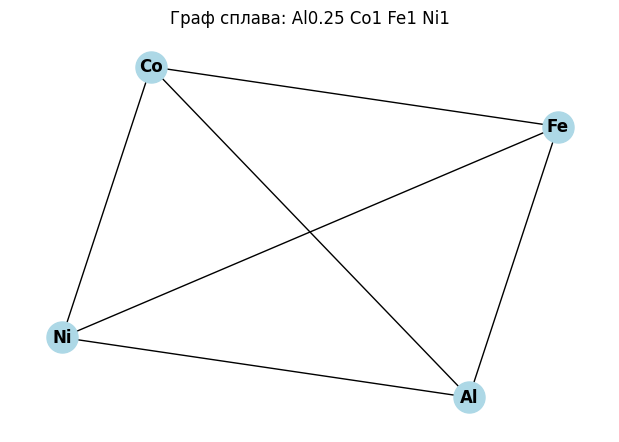

In [ ]:
def visualize_graph(composition: dict, formula: str):
    G = build_alloy_graph(composition)
    plt.figure(figsize=(6, 4))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12, font_weight='bold')
    plt.title(f"Граф сплава: {formula}")
    plt.show()

sample_row = df_clean.iloc[0]
composition = parse_formula(sample_row['FORMULA'])
visualize_graph(composition, sample_row['FORMULA'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Средняя абсолютная ошибка (MAE): 68.37
Среднеквадратичная ошибка (RMSE): 92.36
Коэффициент детерминации (R²): 0.81


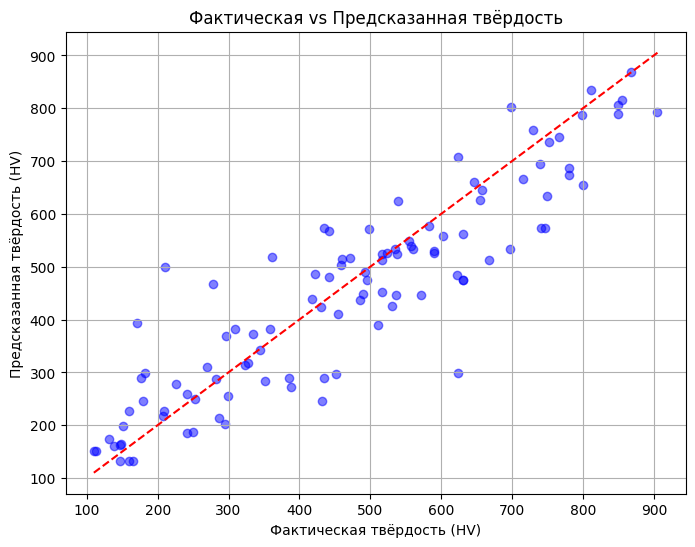

In [ ]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
    print(f"Среднеквадратичная ошибка (RMSE): {rmse:.2f}")
    print(f"Коэффициент детерминации (R²): {r2:.2f}")
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

def plot_predictions(y_true, y_pred, title='Фактическая vs Предсказанная твёрдость'):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Фактическая твёрдость (HV)')
    plt.ylabel('Предсказанная твёрдость (HV)')
    plt.title(title)
    plt.grid(True)
    plt.show()

y_pred_test = best_model.predict(X_test)
metrics = evaluate_model(y_test, y_pred_test)
plot_predictions(y_test, y_pred_test)